In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import scipy.misc
import os
from tqdm import tqdm

Log-Mel Spectrogram generation of all the audio clips in the dataset <br/>
Source : https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html

In [17]:
def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out

In [18]:
def stft(X, datasize=400, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, datasize, step)

    size = datasize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X, fftsize)[:, :cut]
    return X

def pretty_spectrogram(d,datasize=400,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d,datasize, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))

    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram+1e-8) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold

    return specgram

In [19]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# From https://github.com/jameslyons/python_speech_features

def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)
    
def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

In [20]:
def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"
    
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300,
end_freq = 8000, samplerate=16000):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(nfilt=n_freq_components, 
                                           nfft=fft_size, samplerate=samplerate, 
                                           lowfreq=start_freq, highfreq=end_freq)
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
#     mel_spec = scipy.misc.imresize(mel_spec.astype('float64'), (40, 32),
#     interp='nearest')                                           # changed this bit myself
    mel_spec = mel_spec.astype('float64') 
    return mel_spec

In [83]:
### Parameters ###
datasize = 400    # this is 25ms of data as sampling rate of the wav files are 16 kHz
fft_size = 1024*4 # window size for the FFT
step_size = 160 # distance to slide along the window (10 ms in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
n_mel_freq_components = 40 # number of mel frequency channels
shorten_factor = 3.3 # how much should we compress the x-axis (time)
start_freq = 100 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 


The generation of the spectrogram for wave files in the training, validation and test dataset 

Wav_spec dimensions (100, 2048)
Mel_spec dimensions (40, 100)


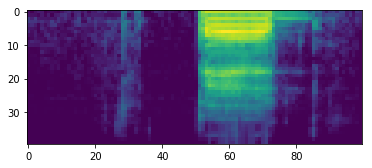

In [84]:
#Testing with one wave
mywav = './data/bed/00176480_nohash_0.wav'
mywav = './data_train/data/bed/00176480_nohash_0.wav'
rate, data = wavfile.read(mywav)
wav_spectrogram = pretty_spectrogram(data.astype('float64'),datasize, fft_size = fft_size,
                                   step_size = step_size, log = True, thresh = spec_thresh)

mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)
mel_spec = make_mel(wav_spectrogram, mel_filter)
print 'Wav_spec dimensions', wav_spectrogram.shape
print 'Mel_spec dimensions', mel_spec.shape
plt.imshow(mel_spec)

In [43]:
# dataPath = './data_train/data/'
savePath = './test_data_lmel'
dataPath = './train_data/l'
# savePath = './validation_data'
# dataPath = './test'
# savePath = './test_data'
if not os.path.isdir(savePath):
    os.makedirs(savePath)

In [44]:
# LEGACY CODE

f = []
for path, subdirs, files in os.walk(dataPath):
    for name in files:
        f.append(os.path.join(path, name))
print "Found %d files" % len(f)

for mywav in tqdm(f):
    s = mywav.split('/')
    if s[2] == '_background_noise_':
        print 'skipping noise'
        continue
    out_name = s[2]+'_'+s[3].split('.')[0]+'.jpeg'
    rate, data = wavfile.read(mywav)
    wav_spectrogram = pretty_spectrogram(data.astype('float64'),datasize, fft_size = fft_size,
                                       step_size = step_size, log = True, thresh = spec_thresh)
 
    mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq)
    mel_spec = make_mel(wav_spectrogram, mel_filter)
    scipy.misc.imsave(savePath+'/'+out_name, np.array(mel_spec))

  0%|          | 5/44876 [00:00<16:55, 44.18it/s]

Found 44876 files


  0%|          | 60/44876 [00:01<15:24, 48.46it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
  1%|          | 289/44876 [00:05<15:01, 49.48it/s]


KeyboardInterrupt: 

In [61]:
def generate(dataPath, savePath, test=False):
    f = []
    for path, subdirs, files in os.walk(dataPath):
        for name in files:
            f.append(os.path.join(path, name))
    print "Found %d files" % len(f)
    n = './data_train/data/_background_noise_/white_noise.wav'
    rate, noise = wavfile.read(n)
    noise = 0.01*noise[:16000]
    for mywav in tqdm(f):
        s = mywav.split('/')
#         print s
    #     if s[2] == '_background_noise_':
    #         print 'skipping noise'
    #         continue
        if s[-1].split('.')[-1] != 'wav':
            print "skipping non wav files"
            continue
        if not test:
            out_name = s[3]+'_'+s[4].split('.')[0]+'.jpeg'
#             print out_name
        else:
            out_name = s[-1].split('.')[0]+'.jpeg'
    #     out_name = s[2]+'_'+s[3].split('.')[0]+'.jpeg'
        rate, data = wavfile.read(mywav)

        if len(data) < 16000:
            data = np.concatenate((data, np.zeros(rate - len(data))))
            data = data + noise
        else:
            data = data[:16000]


        wav_spectrogram = pretty_spectrogram(data.astype('float64'),datasize, fft_size = fft_size,
                                           step_size = step_size, log = True, thresh = spec_thresh)

        mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                                n_freq_components = n_mel_freq_components,
                                                                start_freq = start_freq,
                                                                end_freq = end_freq)
        mel_spec = make_mel(wav_spectrogram, mel_filter)
        if mel_spec.shape[1] !=100:
            print 'scam'
        scipy.misc.imsave(savePath+'/'+out_name, np.array(mel_spec))

In [86]:
train = './data_train/data/'
savetrain = './train_data_lmel'
train_test = './data_train/test/'
train_val = './data_train/validation/'

test = './data_train/kaggle_test/'
savetest = './test_data_lmel/'
# savePath = './validation_data'
# dataPath = './test'
# savePath = './test_data'


generate('./data_train/data/', './lmel_train4/')
generate('./data_train/test/', './lmel_test4/')
generate('./data_train/validation/', './lmel_v4/')
generate('./data_train/kaggle_test/', './lmel_kaggle4/', True)

  0%|          | 5/51095 [00:00<18:50, 45.20it/s]

Found 51095 files


 19%|█▉        | 9779/51095 [03:12<13:31, 50.93it/s]

skipping non wav files


 30%|██▉       | 15096/51095 [04:56<11:45, 50.99it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
  0%|          | 5/6835 [00:00<02:17, 49.77it/s]

Found 6835 files


  0%|          | 5/6798 [00:00<02:32, 44.55it/s]

Found 6798 files


  0%|          | 6/158539 [00:00<52:21, 50.47it/s]

Found 158539 files


 75%|███████▍  | 118299/158539 [39:47<13:32, 49.55it/s]

skipping non wav files


100%|██████████| 158539/158539 [53:13<00:00, 49.65it/s]
